# Implementing K-NN alogrithm for two datasets

Simple implementation of the K-NN working with two datasets:
* breast-cancer-wisconsin.data  
(https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)
* haberman.data  
(https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data)

`KNN` function should work with any dataFrame with numerical values and the class label to predict in the last column, as long as there are no NaN values.  
  
  
The `loadAndSplitDataSet`, as well as the plot functions, are specific for the two mentionned above data sets: they aim to clean the data and represent the obtained results.

In [1]:
# Importing usefull packages and modules
import math
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Load data set and train/test split function  
This function loads the _breast-cancer-wisconsin_ or _haberman_ data set into two disctint dataframes that are easier to manipulate. One corresponds to the train, the other to the test.  
The size of the test set has to be specified with a `testSize` parameter.  
The distribution between the two dataframes is random: results may vary if one performs several tests.

In [2]:
def loadAndSplitDataSet(dataSetFile, testSize):
    
    # Creating dataFrame with panda
    na_values = ['?']
    df = pd.read_csv(dataSetFile, sep=',',
                     header=None, na_values=na_values)
    
    # Adding column names according to the chosen data set
    if dataSetFile == 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data':
        # First column ignored for breast-cancer-wisconsin.data
        df = df.iloc[:,1::]
        
        df.columns = ['Clump Thickness',
             'Uniformity of Cell Size',
             'Uniformity of Cell Shape',
             'Marginal Adhesion',
             'Single Epithelial Cell Size',
             'Bare Nuclei',
             'Bland Chromatin',
             'Normal Nucleoli',
             'Mitoses',
             'Class']
    else:
        df.columns = ['Age',
                      'Operation Year',
                      'Positive axillary',
                      'Survival status']
    
    # Dropping all NaN values
    if df.isnull().values.any():
        print('{}: dropping {} rows with NaN values \n'.format(dataSetFile,
                                                               df.isnull().sum().sum()))
        df = df.dropna()
    
    # Random train test split using sklearn
    train_set_df, test_set_df = train_test_split(df, test_size=testSize)
    
    return train_set_df, test_set_df

## KNN functions  
Here are some usefull functions that the KNN algorithm uses:  
* `compute_distance`:  
Return the distance beetween to points `x1` and `x2`. One can specify the `p` parameter. With `p=2`, you will get the euclidian distance.  
* `getNeighbors`:  
This function computes the distance beetween a `test_point` and each point of a `trainingSet`. It then returns the `k` closest "neighbors" according to the computed distances.
* `getBestMatch`:  
Return the best predicted class depending on a set of neigbhors. It corresponds to the class distributed in majority among these neighbors. In equality case for several best classes, one is chosen randomly. 
* `getAccuracy`:  
Return the accuracy percentage by comparing the predited classes with the true class for a test set of observations.
* `getConfusionMatrix`:  
Using sklearn, return the confusion matrix highlighting false positives and true negatives for a prediction.

In [3]:
def compute_distance(x1, x2, p=2):
    distance = 0
    
    for i in range(len(x1)):
        distance += (x1[i] - x2[i])**p
        
    return distance**(1/p)

def getNeighbors(trainingSet, test_point, k, p):
    distances_and_indices =  []
    # Distance for each point in the training set
    for index, training_point in enumerate(trainingSet):
        # [:-1] corresponds to the point coordinates. [-1] is the class
        distance = compute_distance(test_point[:-1], training_point[:-1], p)
        distances_and_indices.append([distance, index])
    
    distances_and_indices = sorted(distances_and_indices)
    
    # Getting only the K closests
    neighbors_indices = [distances_and_indices[i][1] for i in range(k)]

    # Retrieving the neighbors observations with indices
    neighbors = [trainingSet[i] for i in neighbors_indices]

    return neighbors

def getBestMatch(neighbors):
    # Counter for each neighbor[-1] class
    c = Counter([neighbor[-1] for neighbor in neighbors])
    # Returning the most common class
    return c.most_common(1)[0][0]

def getAccuracy(testSet, predictions):
    errors = []
    for i in range(len(testSet)):
        # Computing the error. If error !=0, the prediction is false.
        errors.append(testSet[i][-1] - predictions[i])
    # Total number of prediction errors
    error_count = np.count_nonzero(errors)
    # Returning accuracy ratio
    return (float)(1 - (error_count/len(testSet)))

def getConfusionMatrix(testSet, predictions):
    # True class list
    true_classes = [test_observation[-1] for test_observation in testSet]
    # Confusion matrix with sklearn
    return confusion_matrix(true_classes, predictions)

## Plot data and confusion matrix  
Here are some functions used to plot and visualize the results. 
  
  
A function found on scikit-learn gives us a "sexier" look for the confusion matrix.  
A specific plot function has been made for each _breast cancer_ and _haberman_ data set:  
* For the _breast cancer_ data set, a 2D plot is made for each pair of coordinates that have been specified in the `variable_couples` argument. As many points may overlap each over with the data distribution, class 1 is displayed with bigger points.
* For the _haberman_ data set, results are displayed in a 3 dimensional space.  
  
  
Correct predicted values are displayed in green or blue depending on their class. Wrong predicted values are displayed with red color.

In [4]:
# Function which display the confusion matrix
# Found on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    
    print('Confusion matrix: \n')
    print(conf_matrix)
    print('\n')
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot the results for the haberman data set
def plot_data_haberman(test_Set, predictions):
    # local copy of the test_set dataframe:
    # We don't want to alter the original one if we run the KNN with other K values
    testSet = test_Set.copy()
    testSet['Prediction'] = predictions
    
    fig = plt.figure(1, figsize=(8, 8))
    ax = Axes3D(fig)

    # Getting unique classes
    classes = sorted(testSet['Survival status'].unique().tolist())

    # All correct predicted class 1
    class_1 = testSet[(testSet['Survival status'] == classes[0]) &
                              (testSet['Survival status'] == testSet['Prediction'])]

    # All correct predicted class 2
    class_2 = testSet[(testSet['Survival status'] == classes[1]) &
                              (testSet['Survival status'] == testSet['Prediction'])]

    # All wrong predictions
    errors = testSet[testSet['Survival status'] != testSet['Prediction']]

    # 3D Plot
    ax.scatter(class_1['Age'],
               class_1['Operation Year'],
               class_1['Positive axillary'], 'o', color='Blue', label='Benign')

    ax.scatter(class_2['Age'],
               class_2['Operation Year'],
               class_2['Positive axillary'], 'o', color='Green', label='Malignant')

    ax.scatter(errors['Age'],
               errors['Operation Year'],
               errors['Positive axillary'], 'o', color='Red', label='Prediction error')

    ax.set_xlabel('Age of patient at time of operation')
    ax.set_ylabel('Patient\'s year of operation')
    ax.set_zlabel('Number of positive axillary nodes detected')
    ax.legend()
    plt.show()

def plot_data_breast_cancer(test_Set, predictions, variable_couples):
    # local copy of the test_set dataframe:
    # We don't want to alter the original one if we run the KNN with other K values
    testSet = test_Set.copy()
    testSet['Prediction'] = predictions

    # As many plots as variable couples
    for variable_couple in variable_couples:          
        fig = plt.figure(1, figsize=(8, 8))

        # Getting unique classes
        classes = sorted(testSet['Class'].unique().tolist())

        # All correct predicted class 1
        class_1 = testSet[(testSet['Class'] == classes[0]) &
                                  (testSet['Class'] == testSet['Prediction'])]

         # All correct predicted class 2
        class_2 = testSet[(testSet['Class'] == classes[1]) &
                                  (testSet['Class'] == testSet['Prediction'])]

        # All wrong predictions
        errors = testSet[testSet['Class'] != testSet['Prediction']]

        # 2D Plot
        plt.plot(class_1[variable_couple[0]],
                   class_1[variable_couple[1]], 'o', color='Blue', markersize=12, label='Survived')

        plt.plot(class_2[variable_couple[0]],
                   class_2[variable_couple[1]], 'o', color='Green', label='Died')

        plt.plot(errors[variable_couple[0]],
                   errors[variable_couple[1]], 'o', color='Red', label='Prediction error')

        plt.xlabel(variable_couple[0])
        plt.ylabel(variable_couple[1])
        plt.legend()
        plt.show()

### KNN function  
The KNN algorithm function, perfomed on a `training_set_df` and `test_set_df`. `k`, the number of nearest neighbors, is specified as an argument, as well as the `p` parameter used for the distance calcul.  
For performance reasons, we don't apply the alogrithm directly on the dataframes, but we convert each one in a list format.

In [5]:
def KNN(training_set_df, test_set_df, k, p):
    
    trainingSet = []
    testSet = []
    
    # Converting training and test sets dataframes to lists
    for _, data_row in training_set_df.iterrows():
        trainingSet.append(data_row.values.tolist())
    
    for _, data_row in test_set_df.iterrows():
        testSet.append(data_row.values.tolist())
        
    predictions = []

    # KNN prediction for each observation in the test set
    for observation in testSet:
        neighbors = getNeighbors(trainingSet, observation, k, p)
        predictions.append(getBestMatch(neighbors))
    
    # Accuracy of the prediction
    accuracy = getAccuracy(testSet, predictions)

    # Confusion Matrix
    conf_matrix = getConfusionMatrix(testSet, predictions)
    
    return predictions, accuracy, conf_matrix

### Main function  
Perform the KNN algorithm on each data set and plot the results.  
One can specify the `test_set_size`, as well as a list of `k_values` to use.

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data: dropping 16 rows with NaN values 

KNN algorithm for breast-cancer-wisconsin.data with k=3: 

Accuracy: 0.9778761061946902 

Confusion matrix: 

[[140   3]
 [  2  81]]




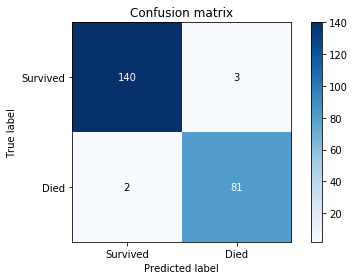

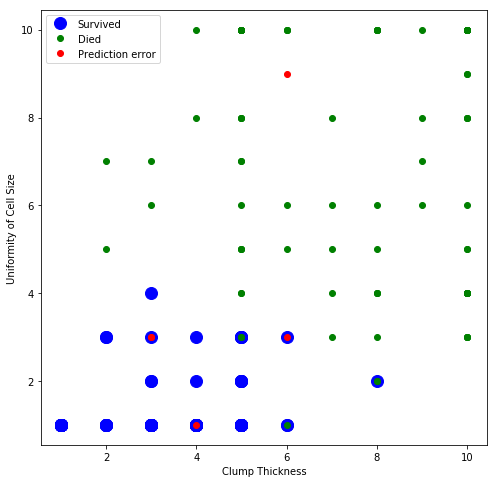

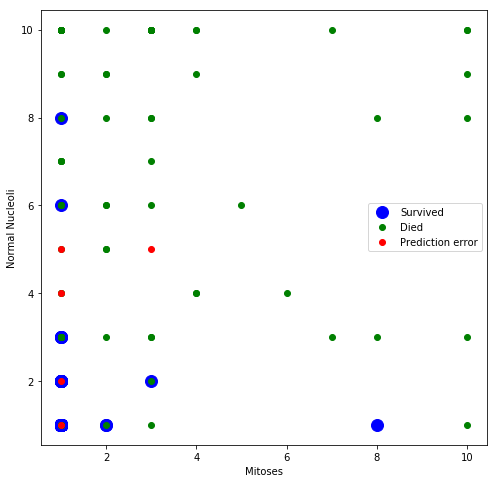

KNN algorithm for breast-cancer-wisconsin.data with k=6: 

Accuracy: 0.9823008849557522 

Confusion matrix: 

[[140   3]
 [  1  82]]




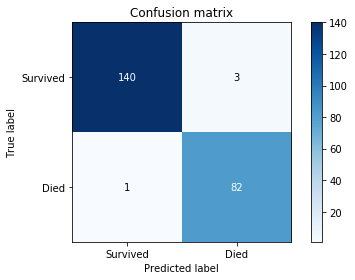

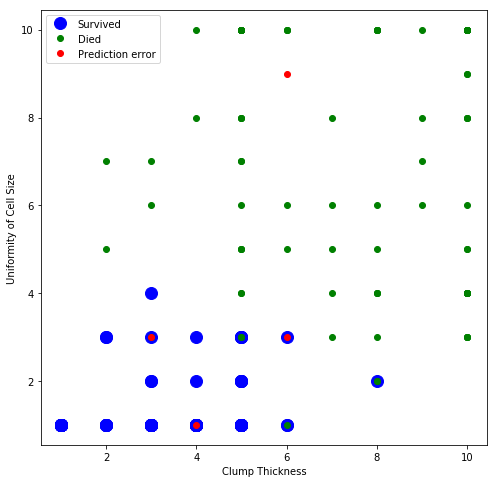

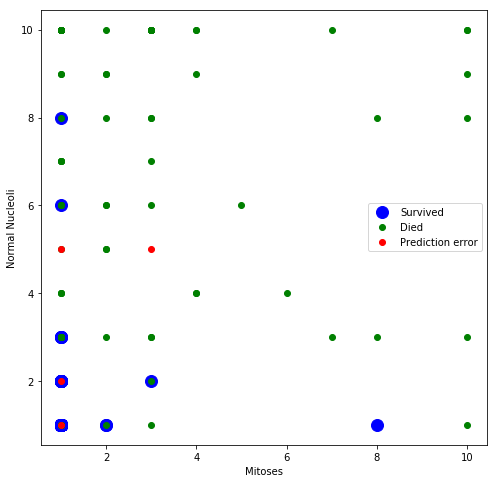

KNN algorithm for haberman.data with k=3: 

Accuracy: 0.7029702970297029 

Confusion matrix: 

[[60 14]
 [16 11]]




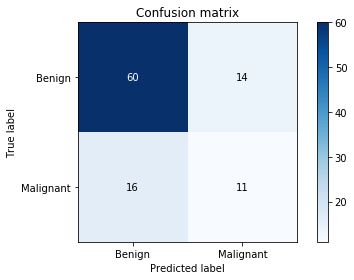

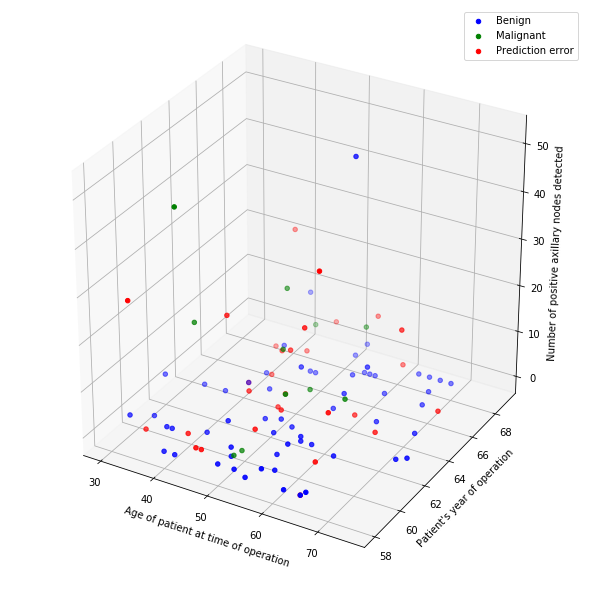

KNN algorithm for haberman.data with k=6: 

Accuracy: 0.7722772277227723 

Confusion matrix: 

[[70  4]
 [19  8]]




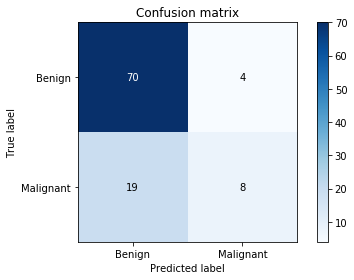

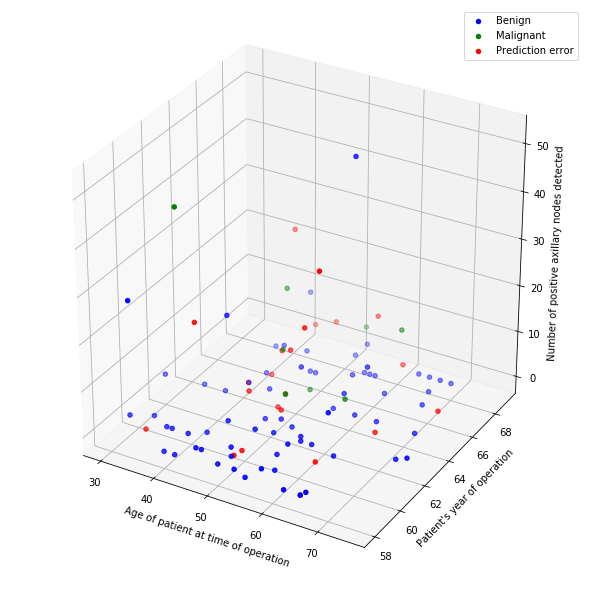

In [6]:
############ Parameters ##################################
test_set_size = 0.33
k_values = [3, 6]

############ Breast cancer wisconsin data set ############
dataSetFile = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
training_set_breast_cancer, test_set_breast_cancer = loadAndSplitDataSet(dataSetFile, test_set_size)

for k in k_values:
    print('KNN algorithm for breast-cancer-wisconsin.data with k={}: \n'.format(k))
    
    predictions, accuracy, conf_matrix = KNN(training_set_breast_cancer, test_set_breast_cancer, k, 2)
    
    print('Accuracy: {} \n'.format(accuracy))
    
    plot_confusion_matrix(conf_matrix, ['Survived', 'Died'])
    
    # Here you can specify the variable couples you want to examinate and plot
    variable_couples = [['Clump Thickness', 'Uniformity of Cell Size'],
                         ['Mitoses', 'Normal Nucleoli']]
    
    plot_data_breast_cancer(test_set_breast_cancer, predictions, variable_couples)

############ haberman data set ###########################
dataSetFile = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
training_set_haberman, test_set_haberman = loadAndSplitDataSet(dataSetFile, test_set_size)
    
for k in k_values:
    print('KNN algorithm for haberman.data with k={}: \n'.format(k))
    
    predictions, accuracy, conf_matrix = KNN(training_set_haberman, test_set_haberman, k, 2)
    
    print('Accuracy: {} \n'.format(accuracy))
    
    plot_confusion_matrix(conf_matrix, ['Benign', 'Malignant'])
    
    plot_data_haberman(test_set_haberman, predictions)